# Credit Scoring Using Machine Learning

## Random Forest Credit Scoring

- Giacomo Di Prinzio
- Umberto Rubino
- Davide Ritaccio
- Giulia Carletti

## Librerie

In [170]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [171]:
import pandas as pd
from sklearn import ensemble
from sklearn import metrics
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

## Caricamento dati

### Training set

In [172]:
dtypes = {"COD_SAE":str, "DAT_COSTITUZIONE":str}

In [173]:
train_data = pd.read_csv("/home/bigdive/Desktop/BDINTESA/project_work/CONTEST_TRAINING_SET_PUBBLICO.CSV", dtype = dtypes) 

In [174]:
train_data.head()

,ID,COD_CAP,COD_PROVINCIA,DAT_COSTITUZIONE,COD_RAE,COD_SAE,COD_ISTAT_ATECO_07,FLG_DEF_6M,CBI201312_CREDITI,CBI201312_UTILE_PERDITA_ESERCIZIO,CBI201312_PATRIMONIO_NETTO,CBI201312_DEBITI_CONSOLIDATI,CBI201312_DEBITI_ENTRO_ES_SUCC,CBI201312_RICAVI_NETTI,CBI201312_ACQUISTI_NETTI,CBI201312_COSTI_SERVZ_BENI_TERZI,IMP_ACCORDATO,IMP_UTILIZZATO,IMP_VALORE_GARANZIA
0,1,83013.0,AV,1977.0,243,430,4120.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,135220.0,0.0
1,2,84131.0,SA,1984.0,614,492,4719.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,844348.0,1054419.0,0.0
2,3,82030.0,BN,1952.0,12,430,11021.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332366.0,0.0
3,4,80133.0,NaN,1982.0,830,430,4120.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,51762483.0,0.0
4,5,72021.0,BR,1989.0,419,482,10711.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37562.0,34857.0,0.0


### Test set & solution set

In [175]:
test_data = pd.read_csv("/home/bigdive/Desktop/BDINTESA/project_work/CONTEST_TEST_SET_PUBBLICO.csv", dtype = dtypes)

In [176]:
sol_data = pd.read_csv("/home/bigdive/Desktop/BDINTESA/project_work/CONTEST_TEST_RESULTS_AN_PRIVATO.csv")

In [177]:
print "Dimensioni training set:\t" , shape(train_data)
print "Dimensioni test set:\t\t" , shape(test_data)
print "Dimensioni result set:\t\t" , shape(sol_data)

Dimensioni training set:	(66811, 19)
Dimensioni test set:		(7547, 18)
Dimensioni result set:		(7547, 2)


### Focus valori mancanti

In [178]:
mask = [~train_data.ix[i].isnull().any() for i in range(len(train_data))]

In [179]:
print 'Tasso di default (training set completo):\t\t\t', sum(train_data['FLG_DEF_6M'])*1.0/len(train_data)
print 'Tasso di default (training set al netto dei Nan):\t\t', sum(train_data['FLG_DEF_6M'][mask])*1.0/len(train_data[mask])
print 'Tasso di default (sotto campione contenente Nan):\t\t', sum(train_data['FLG_DEF_6M'][np.invert(mask)])*1.0/len(train_data[np.invert(mask)])
print 'Percentuale righe piene:\t\t\t\t\t', sum(mask)*1.0/len(mask)

Tasso di default (training set completo):			0.165571537621
Tasso di default (training set al netto dei Nan):		0.138160834677
Tasso di default (sotto campione contenente Nan):		0.257528353539
Percentuale righe piene:					0.770367155109


Il cambiamento del tasso di default, senza le righe che contengono ALMENO UN Nan, e' basso, il che potrebbe indurre alla scelta di eliminare suddette righe. 
Malgrado cio', analizzando il tasso di default nel sotto campione costrituito aggregando le sole controparti nei cui campi compare almeno un Nan, si osserva un tasso di default sensibilmente diverso: qui superiore al 25%.
Da questo si deduce che la presenza di Nan e' particolarmente concentrata nelle controparti in default e che, dunque, rimuovere suddette controparti dal dataset potrebbe introdurre dei bias e/op rimuovere informazioni utili.

## Ottimizzazione dataset

In [180]:
test_data["FLG_DEF_6M"] = -9999

In [181]:
X =train_data["FLG_DEF_6M"]
train_data.drop(labels="FLG_DEF_6M",axis=1,inplace=True)
train_data["FLG_DEF_6M"]=X

In [182]:
db = pd.concat([train_data, test_data]).reset_index(drop=True)

## Scelta campi da eliminare

Il campo ATECO contiene la medesima informazione dei campi SAE - RAE. Avendo il primo una percentuale di missing del 4% e volendo evitare multicolinearita' nelle variabili, si e' scelto di eliminarlo.
La scelta tra RAE e SAE e' stata operata sulla base della rappresentativita' : la prima ha molte piu' categorie della seconda e per evitare una classificazione troppo "raffinata" si e' mantenuta la seconda (SAE).

In [183]:
sae= db["COD_RAE"].unique()
print len(sae)

186


In [184]:
sae= db["COD_SAE"].unique()
len(sae)

29

In [185]:
db.drop(labels="COD_PROVINCIA",axis=1,inplace=True) 

In [186]:
db.drop(labels="COD_RAE",axis=1,inplace=True) 

In [187]:
db.drop(labels="COD_ISTAT_ATECO_07",axis=1,inplace=True)

## Data cleaning: Nan

Sono state eseguite prove sostituendo i Nan con:
- zeri
- valori medi di colonna
- mediana colonna
- valore fittizio (i.e. -99999)

La scelta finale e' riscaduta sul valore 0 per diversi motivi:
- a seguito dei risultati di alcune prove di machine learning;
- evitare overfitting usando la media delle osservazioni del campione di sviluppo.

In [188]:
db = db.fillna(0) #sostituisco gli NA con 0

- AUC: 0.871034764006 (con -999999)
- AUC: 0.873450448055 (con 0)
- AUC: 0.873392986888 (con medie)
- AUC: 0.872525509275 (con mediane)

Scegliamo il valore zero per sostituire i NaN!

## Arricchimento base dati

### Da cap a regione

Il dato sulle province ci e' parso troppo puntuale e aggregare per regione apre a nuovi sviluppi del modello.

In [189]:
def cap2reg(cap):
    cap = int(cap)
    if (64010 <= cap) & (cap <= 67100):
        return "Abruzzo"
    elif (75010 <= cap) & (cap <= 85100):
        return "Basilicata"
    elif (87010 <= cap) & (cap <= 89900):
        return "Calabria"
    elif (80010 <= cap) & (cap <= 84135):
        return "Campania"
    elif (29010 <= cap) & (cap <= 48125):
        return "Emilia Romagna"
    elif (33010 <= cap) & (cap <= 34170):
        return "Friuli Venezia Giulia"
    elif (10 <= cap) & (cap <= 4100):
        return "Lazio"
    elif (12071 <= cap) & (cap <= 19137):
        return "Liguria"
    elif (20010 <= cap) & (cap <= 46100):
        return "Lombardia"
    elif (60010 <= cap) & (cap <= 63900):
        return "Marche"
    elif (86010 <= cap) & (cap <= 86170):
        return "Molise"
    elif (10010 <= cap) & (cap <= 28925):
        return "Piemonte"
    elif (70010 <= cap) & (cap <= 76125):
        return "Puglia"
    elif (7010 <= cap) & (cap <= 9170):
        return "Sardegna"
    elif (90010 <= cap) & (cap <= 98168):
        return "Sicilia"
    elif (50012 <= cap) & (cap <= 59100):
        return "Toscana"
    elif (38010 <= cap) & (cap <= 39100):
        return "Trentino Alto Adige"
    elif (5010 <= cap) & (cap <= 6135):
        return "Umbria"
    elif (11010 <= cap) & (cap <= 11100):
        return "Valle D'Aosta"
    elif (30010 <= cap) & (cap <= 45100):
        return "Veneto"
    else:
        return None

In [190]:
db["REGIONE"] = db["COD_CAP"].map(cap2reg, na_action='ignore')
#db.head()

In [191]:
db.drop(labels="COD_CAP", axis=1, inplace=True)

### Creazione dummies

In [192]:
features = ["DAT_COSTITUZIONE", "COD_SAE", "REGIONE"]

In [193]:
%%time
db=pd.concat([db, pd.get_dummies(db[features], columns=features)], axis=1)
db.drop(features, axis=1, inplace=True)

CPU times: user 408 ms, sys: 756 ms, total: 1.16 s
Wall time: 1.4 s


In [194]:
%%time 
db["FLAG_GARANZIA"]=0
for el in db.IMP_VALORE_GARANZIA:
    if el>0.0:
        db["FLAG_GARANZIA"]=1

CPU times: user 3 s, sys: 12 ms, total: 3.02 s
Wall time: 3.06 s


### Nuove Features finanziarie

In [195]:
db["IMP_UTILIZZATO/IMP_ACCORDATO"] = db.IMP_UTILIZZATO.div(db.IMP_ACCORDATO)

In [196]:
#db["IMP_UTILIZZATO/IMP_ACCORDATO"].isnull().sum()*1.0/db.shape[0]

In [197]:
#(db["IMP_UTILIZZATO/IMP_ACCORDATO"] == inf).sum()*1.0/len(db["IMP_UTILIZZATO/IMP_ACCORDATO"])

In [198]:
#(db["IMP_UTILIZZATO/IMP_ACCORDATO"] == -inf).sum()*1.0/len(db["IMP_UTILIZZATO/IMP_ACCORDATO"])

In [199]:
db["IMP_UTILIZZATO/IMP_ACCORDATO"] = db.IMP_UTILIZZATO.div(db.IMP_ACCORDATO).replace(inf, 1).replace(nan,0)

In [200]:
db["CBI201312_DEBITI_CONSOLIDATI/CBI201312_CREDITI"] = db.CBI201312_DEBITI_CONSOLIDATI.div(db.CBI201312_CREDITI)

In [201]:
#(db["CBI201312_DEBITI_CONSOLIDATI/CBI201312_CREDITI"] == inf).sum()*1.0/len(db["CBI201312_DEBITI_CONSOLIDATI/CBI201312_CREDITI"])

In [202]:
#db["CBI201312_DEBITI_CONSOLIDATI/CBI201312_CREDITI"].isnull().sum()*1.0/db.shape[0]

In [203]:
db["CBI201312_DEBITI_CONSOLIDATI/CBI201312_CREDITI"] = db.CBI201312_DEBITI_CONSOLIDATI.div(db.CBI201312_CREDITI).replace(inf, 1).replace(nan,0)

In [204]:
db["CBI201312_DEBITI_ENTRO_ES_SUCC/CBI201312_CREDITI"] = db.CBI201312_DEBITI_ENTRO_ES_SUCC.div(db.CBI201312_CREDITI)

In [205]:
#(db["CBI201312_DEBITI_ENTRO_ES_SUCC/CBI201312_CREDITI"] == inf).sum()*1.0/len(db["CBI201312_DEBITI_ENTRO_ES_SUCC/CBI201312_CREDITI"])

In [206]:
#db["CBI201312_DEBITI_ENTRO_ES_SUCC/CBI201312_CREDITI"].isnull().sum()*1.0/db.shape[0]

In [207]:
db["CBI201312_DEBITI_ENTRO_ES_SUCC/CBI201312_CREDITI"] = db.CBI201312_DEBITI_ENTRO_ES_SUCC.div(db.CBI201312_CREDITI).replace(inf,1).replace(nan, 0)

In [208]:
#db.isnull().sum().sum()

In [209]:
temp = db['FLG_DEF_6M']
db.drop(labels=['FLG_DEF_6M'],axis=1,inplace = True)
db.insert(1,'FLG_DEF_6M',temp)
del temp

# Modello

In [210]:
train = db[db.FLG_DEF_6M >= 0]

In [211]:
test = db[db.FLG_DEF_6M < 0]

In [212]:
test.drop(labels="FLG_DEF_6M",axis=1,inplace=True) 

/home/bigdive/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [213]:
test.drop(labels="ID",axis=1,inplace=True) 

/home/bigdive/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [214]:
X = train[train.columns[2:]] #tolgo ID e flag

In [215]:
y = train["FLG_DEF_6M"]

### Run del Modello e relative stime

La logica dei decision trees e' suddividere il feature space in regioni con stesso label.
Il RandomForest qui utilizzato si ispira a questa logica ma e' un cosiddetto Ensemble Methods, in quanto combina diversi algoritmi di base per migliorare il modello.

<img src= "https://docs.microsoft.com/en-us/azure/machine-learning/media/machine-learning-algorithm-choice/image5.png">

In [216]:
random.seed(0)

In [217]:
%%time

model = ensemble.RandomForestClassifier(n_estimators=100, random_state=15)
model.fit(X, y)

CPU times: user 30.4 s, sys: 172 ms, total: 30.6 s
Wall time: 30.7 s


In [218]:
y_true = ravel(sol_data["FLG_DEF_6M"])

AUC: 0.893842695816


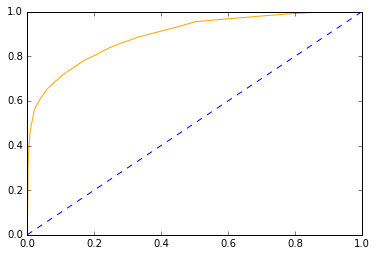

In [219]:
y_pred = model.predict_proba(test)
fpr, tpr, _ = metrics.roc_curve(ravel(sol_data["FLG_DEF_6M"]) , y_pred[:,1])
print "AUC:", metrics.auc(fpr, tpr)
plot ([0,1] , [0,1],"--",fpr,tpr,"orange")
show()

In [220]:
y_pred_1_e_0 = model.predict(test)

In [221]:
pd.options.display.max_rows = 500

In [222]:
pd.DataFrame([y_pred[:,1],y_pred_1_e_0]).T

,0,1
0,0.20,0.0
1,0.19,0.0
2,0.21,0.0
3,0.06,0.0
4,0.01,0.0
5,0.07,0.0
6,0.12,0.0
7,0.00,0.0
8,0.01,0.0
9,0.03,0.0


### Confusion Matrix

$$
{\rm confusion matrix:~~~} {\bf X}~=~\left[
\begin{matrix}
previsto\ bonis-e' bonis & previsto\ default-e' bonis\\
previsto\ bonis-e' default & previsto\ default-e'default\\
\end{matrix}
\right]
$$

In [223]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred_1_e_0)

array([[6156,   80],
       [ 655,  656]])

AR = proporzione predette correttamente

In [224]:
#Accuracy ratio
AR = (6156+656)*1.0/(6156+80+655+656)
print "Accuracy ratio:\t", AR

#Precision (positive predected value)
PR = 6156.0/(6156+80)
print "Precision:\t", PR

#Specificity (negative predected value)
SR = 656.0/(656+655)
print "Specificity:\t", SR

Accuracy ratio:	0.902610308732
Precision:	0.987171263631
Specificity:	0.500381388253


## Modello alternativo: bilancio dataset

In [225]:
#pescare random un numeri di bonis pari al numero di default
#non faremo cross validation


In [226]:
#usiamo class_weight 

model = ensemble.RandomForestClassifier(n_estimators=100,  random_state=15, class_weight= {0:1,1:10})
model.fit(X, y)


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=15, verbose=0, warm_start=False)

AUC: 0.893842695816


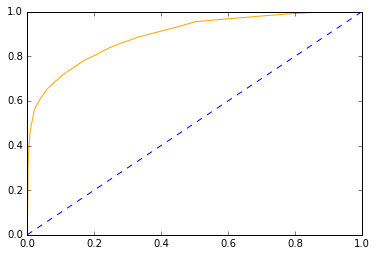

In [227]:

#y_pred = model.predict_proba(test)
fpr, tpr, _ = metrics.roc_curve(ravel(sol_data["FLG_DEF_6M"]) , y_pred[:,1])
print "AUC:", metrics.auc(fpr, tpr)
plot ([0,1] , [0,1],"--",fpr,tpr,"orange")
show()

In [228]:
y_pred_1_e_0_bil = model.predict(test)

In [229]:
confusion_matrix(y_true, y_pred_1_e_0_bil)

array([[6161,   75],
       [ 677,  634]])

In [230]:
#Accuracy ratio
AR_1 = (6161+634)*1.0/(6161+75+677+634)
print "Accuracy ratio:\t", AR_1 , "\t\t(Modello precedente:)\t", AR

#Precision (positive predected value)
PR_1 = 6161.0/(6161+75)
print "Precision:\t", PR_1, "\t\t(Modello precedente:)\t", PR

#Specificity (negative predected value)
SR_1 = 634.0/(634+677)
print "Specificity:\t", SR_1, "\t\t(Modello precedente:)\t", SR

Accuracy ratio:	0.90035775805 		(Modello precedente:)	0.902610308732
Precision:	0.987973059654 		(Modello precedente:)	0.987171263631
Specificity:	0.483600305111 		(Modello precedente:)	0.500381388253


## Not so good!

<img src= "http://scikit-learn.org/stable/_images/sphx_glr_plot_compare_calibration_0011.png">

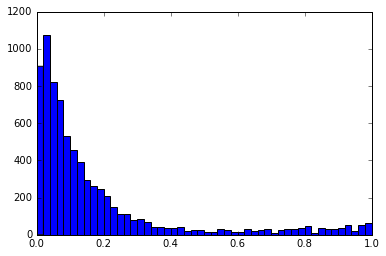

In [231]:
hist(y_pred[:,1], bins=50);